# 3.3.1. Batched training with torch and factories (tg.common.ml.batched_training.factories)

Thousands of training processes have shown `BatchedTrainingTask` is a reliable and effective way of training neural networks. 

However, we experienced some problems with training networks of different architectures on data with complex structures (such as contextual data, see `tg.common.ml.batched_training.context`). These problems are conceptual: the approach of `BatchedTrainingTask` is that the training is a SOLID object entirely configurable by components; however, in the reality the configuration can only be achieved by extensive coding in `ModelHandler` and `lazy_initialization`. 

`tg.common.ml.batched_training.factories` addresses the problem, subclassing and adjusting `BatchedTrainingTask` and `ModelHandler` for this scenario, as well as adding some additional classes for network creation.

## Binary classification task

We will work on binary classification task from standard sklearn datasets. First, we need to translate it into bundle:

In [1]:
from yo_fluq_ds import *
from sklearn import datasets
import pandas as pd
from tg.common.ml import batched_training as bt

def get_binary_classification_bundle():
    ds = datasets.load_breast_cancer()
    features = pd.DataFrame(ds['data'], columns=ds['feature_names'])
    df = pd.DataFrame(ds['target'], columns=['label'])
    df['split'] = bt.train_display_test_split(df, 0.2, 0.2, 'label')
    bundle = bt.DataBundle(index=df, features=features)
    return bundle

get_binary_classification_bundle().features.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [2]:
get_binary_classification_bundle().index.head()

,label,split
0,0,train
1,0,display
2,0,train
3,0,train
4,0,train


We see that index label contains both label and split. This is a recommended way of splitting for `TorchTrainingTask`: set the split in bundle. The reason for this is that we can't really use several splits in batched training the way we did for single frme task, so the whole architecture of splits becomes unusable. Also, when comparing many networks against each other, it's good to ensure that they train on exactly same data.

Let's define the extractors. This part didn't change in comparison with `tg.common.ml.batched_training`

In [3]:
from tg.common.ml.batched_training import factories as btf
from tg.common.ml import dft

def get_feature_extractor():
    feature_extractor = (bt.PlainExtractor
                 .build('features')
                 .index('features')
                 .apply(transformer = dft.DataFrameTransformerFactory.default_factory())
                )
    return feature_extractor
    
def get_binary_label_extractor():
    label_extractor = (bt.PlainExtractor
                   .build(btf.Conventions.LabelFrame)
                   .index()
                   .apply(take_columns=['label'], transformer=None)
                  )
    return label_extractor

def test_extractor(extractor, bundle):
    extractor.fit(bundle)
    return extractor.extract(bundle)

db = get_binary_classification_bundle()
idb = bt.IndexedDataBundle(db.index, db)
test_extractor( get_feature_extractor(), idb).head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,1.097064,-2.073335,1.269934,0.984375,1.568466,3.283515,2.652874,2.532475,2.217515,2.255747,...,1.886690,-1.359293,2.303601,2.001237,1.307686,2.616665,2.109526,2.296076,2.750622,1.937015
1,1.829821,-0.353632,1.685955,1.908708,-0.826962,-0.487072,-0.023846,0.548144,0.001392,-0.868652,...,1.805927,-0.369203,1.535126,1.890489,-0.375612,-0.430444,-0.146749,1.087084,-0.243890,0.281190
2,1.579888,0.456187,1.566503,1.558884,0.942210,1.052926,1.363478,2.037231,0.939685,-0.398008,...,1.511870,-0.023974,1.347475,1.456285,0.527407,1.082932,0.854974,1.955000,1.152255,0.201391
3,-0.768909,0.253732,-0.592687,-0.764464,3.283553,3.402909,1.915897,1.451707,2.867383,4.910919,...,-0.281464,0.133984,-0.249939,-0.550021,3.394275,3.893397,1.989588,2.175786,6.046041,4.935010
4,1.750297,-1.151816,1.776573,1.826229,0.280372,0.539340,1.371011,1.428493,-0.009560,-0.562450,...,1.298575,-1.466770,1.338539,1.220724,0.220556,-0.313395,0.613179,0.729259,-0.868353,-0.397100


In [4]:
test_extractor(get_binary_label_extractor(), idb).head()

,label
0,0
1,0
2,0
3,0
4,0


In `tg.common.ml.batched_training.factories`, `TorchModelHandler` class is defined. A short reminder: `ModelHandler` class should handle initialization, training and prediction of the model. The `TorchModelHandler` addresses the last two in a generic way, and completely outsources the inialization to three entities:
* Network factory
* Optimizer constructor
* Loss constructor

Let's cover the first one. In general, network factory is an arbitrary function that accepts one batch and generates the network. This gives us the opportunity to adjust the network to the input data: the shape of the input data is determined after the extractors are fitted, which is very late in the initialization process.

<AxesSubplot:xlabel='iteration'>

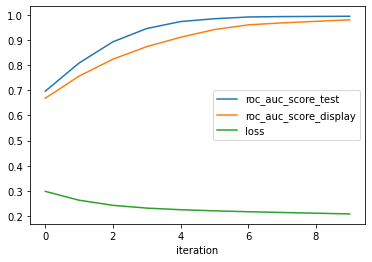

In [5]:
from sklearn.metrics import roc_auc_score
from tg.common import Logger
from functools import partial
import torch

Logger.disable()

class ClassificationNetwork(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ClassificationNetwork, self).__init__()
        self.hidden = torch.nn.Linear(input_size, hidden_size)
        self.output = torch.nn.Linear(hidden_size, output_size)

    def forward(self, input):
        X = input['features']
        X = torch.tensor(X.astype(float).values).float()
        X = self.hidden(X)
        X = torch.sigmoid(X)
        X = self.output(X)
        X = torch.sigmoid(X)
        return X
    
def create_factory(hidden_size):
    return lambda sample: ClassificationNetwork(
        sample['features'].shape[1], 
        hidden_size, 
        sample[btf.Conventions.LabelFrame].shape[1]
    )
        

class ClassificationTask(btf.TorchTrainingTask):
    def initialize_task(self, data):
        self.metric_pool = bt.MetricPool().add_sklearn(roc_auc_score)
        self.settings.epoch_count = 10
        self.settings.batch_size = 1000
        self.settings.mini_match_size = None
        self.setup_batcher(data, [get_feature_extractor(), get_binary_label_extractor()])
        self.setup_model(create_factory(100))
        
        
task = ClassificationTask()
result = task.run(get_binary_classification_bundle())
pd.DataFrame(result['output']['history']).set_index('iteration').plot()

`create_factory` is somewhat of a awkward method that is, essentially, a factory of factories. Moreover, it returns a `lambda` function, which is not compatible with the delivery. Hence, let's consider another way of the factory definition:

<AxesSubplot:xlabel='iteration'>

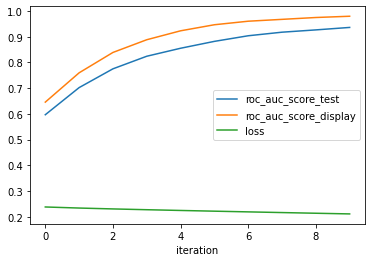

In [6]:
class ClassificationNetwork(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(ClassificationNetwork, self).__init__()
        self.hidden = torch.nn.Linear(input_size, hidden_size)
        self.output = torch.nn.Linear(hidden_size, output_size)

    def forward(self, input):
        X = input['features']
        X = torch.tensor(X.astype(float).values).float()
        X = self.hidden(X)
        X = torch.sigmoid(X)
        X = self.output(X)
        X = torch.sigmoid(X)
        return X
    
    class Factory:
        def __init__(self, hidden_size):
            self.hidden_size = hidden_size
            
        def __call__(self, sample):
            return ClassificationNetwork(
                sample['features'].shape[1], 
                self.hidden_size, 
                sample[btf.Conventions.LabelFrame].shape[1]
            )
        

class ClassificationTask(btf.TorchTrainingTask):
    def initialize_task(self, data):
        self.metric_pool = bt.MetricPool().add_sklearn(roc_auc_score)
        self.settings.epoch_count = 10
        self.settings.batch_size = 1000
        self.settings.mini_match_size = None
        self.setup_batcher(data, [get_feature_extractor(), get_binary_label_extractor()])
        self.setup_model(ClassificationNetwork.Factory(100))
        
        
task = ClassificationTask()
result = task.run(get_binary_classification_bundle())
pd.DataFrame(result['output']['history']).set_index('iteration').plot()

This way the `ClassificationNetwork.Factory` is a proper factory class, containing the parameters of the to-be-created network. `__call__` method makes the object callable. Placing `Factory` inside `ClassificationNetwork` allows you to import these classes always as a couple, and also allows avoiding excessive naming (`ClassificationNetwork` and `ClassificationNetworkFactory`).

Now, to Optimizator constructor. This is an instance of `CtorAdapter` class that turns a type's constuctor into function with unnamed arguments. It contains: 
* a `type`: either an instance of `type` or a string that encodes type the same way we saw in `tg.common.ml.single_frame`
* `args_names`: mapping from the position of the unnamed parameter to the name of the argument in constructor.
* additional named arguments of the constructor.

In [7]:
task.optimizer_ctor.__dict__

{'type': 'torch.optim:SGD', 'args_names': ('params',), 'kwargs': {'lr': 0.1}}

You can simply change the arguments you need.

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)


<AxesSubplot:xlabel='iteration'>

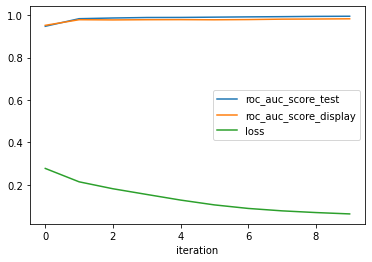

In [8]:
class ClassificationTask(btf.TorchTrainingTask):
    def initialize_task(self, data):
        metrics = bt.MetricPool().add_sklearn(roc_auc_score)
        self.metric_pool = bt.MetricPool().add_sklearn(roc_auc_score)
        self.settings.epoch_count = 10
        self.settings.batch_size = 1000
        self.settings.mini_match_size = None
        self.setup_batcher(data, [get_feature_extractor(), get_binary_label_extractor()])
        
        self.optimizer_ctor.type = 'torch.optim:Adam'
        self.optimizer_ctor.kwargs.lr = 0.01
        self.setup_model(ClassificationNetwork.Factory(100))
        
task = ClassificationTask()
result = task.run(get_binary_classification_bundle())
print(task.model_handler.optimizer)
pd.DataFrame(result['output']['history']).set_index('iteration').plot()

## Other ways of defining network

In the end, we need a network factory: a function, that takes a sample batch and creates a network. As we have seen in the example, the batch is actually used in this creation, as it defines the input size of the network. Note that this is, in general, variable, even for the same task and the same dataset: the transformers that perform one-hot encoding on categorical variables are trained on one batch, therefore, different runs may have slightly different amount of columns in categorical features.

The most understandable way of defining the network and the factory was just presented: to create a `torch` component and a separate `Factory` class accepts the parameters in constructor and creates an object in `__call__`, so the `Factory` object is actually callable and can be invoked as a function. 

**This is perfectly normal and functioning way, and we definitely recommend it for the first attempts.** However, it brings an enourmous amount of bad code in the project. If you change your model even slightly, you either need to create a new `Network/Factory` classes (and probably copy-paste the code), or insert flags. The way to prevent this is to find a way to decompose the factory into components and build the more complicated factory from the basic ones. This would be exactly the way `pytorch` itself works, allowing you to assemble network from basic building blocks.

However, the idea of building a `Factory` for each `pytorch` block, which we initially tried, where `Factory` is a descendant of some `AbstractNetworkFactory` class, was a dead end. It brings in way too much of infrastructure code, which should more or less mirror `pytorch` classes. And when you want to add a new component in your network for an experiment, the last thing you want to do is to also write `Factory` for it.

So we have choosen a more subtle way: allow defining factories as just functions, or even as components themselves. We will list several different ways of creating `Factory` out of component, and to combine them together.

For this, let's first create a batch to test our networks:

In [9]:
batch, _ = task.generate_sample_batch_and_temp_data(get_binary_classification_bundle())
batch['features']

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,1.091268,-2.069159,1.270191,0.990942,1.614542,3.324519,2.653900,2.550951,2.275591,2.254197,...,1.878808,-1.363034,2.310694,2.032141,1.372010,2.571760,2.091379,2.318438,2.741997,1.910886
1,1.825559,-0.373272,1.688311,1.927929,-0.816927,-0.477222,-0.022115,0.556434,0.021409,-0.857298,...,1.797949,-0.383978,1.537466,1.919285,-0.346334,-0.414532,-0.143391,1.105716,-0.237848,0.278243
2,1.575103,0.425332,1.568257,1.573315,0.978863,1.075499,1.364844,2.053164,0.975815,-0.388597,...,1.503541,-0.042597,1.348655,1.476818,0.575486,1.068639,0.848784,1.976310,1.151458,0.199561
3,-0.778611,0.225681,-0.601828,-0.781835,3.355433,3.444899,1.917117,1.464635,2.936619,4.898402,...,-0.291933,0.113602,-0.258640,-0.567665,3.502039,3.823011,1.972584,2.197777,6.021276,4.866911
4,1.745868,-1.160402,1.779387,1.844321,0.307067,0.557671,1.372375,1.441301,0.010268,-0.552360,...,1.289992,-1.469313,1.339664,1.236776,0.262246,-0.299819,0.609293,0.746787,-0.859253,-0.390551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,2.107322,0.686944,2.065033,2.369033,1.079994,0.234744,1.948496,2.338355,-0.297965,-0.919415,...,1.893321,0.097499,1.756248,2.046472,0.423341,-0.260542,0.660138,1.649455,-1.348650,-0.698174
565,1.700331,2.031720,1.617935,1.740531,0.126477,-0.004106,0.694585,1.275632,-0.201410,-1.046472,...,1.528421,2.005692,1.423580,1.516228,-0.668523,-0.379619,0.236277,0.751369,-0.524403,-0.959354
566,0.695662,1.992708,0.669919,0.578957,-0.830652,-0.025125,0.048300,0.111796,-0.803020,-0.884121,...,0.551898,1.340642,0.575427,0.428871,-0.789344,0.351056,0.325611,0.430624,-1.094292,-0.312962
567,1.834097,2.279563,1.986377,1.752063,1.571200,3.313054,3.297800,2.677990,2.193890,1.047151,...,1.953447,2.194096,2.310694,1.677451,1.497305,3.834233,3.169087,2.312328,1.914531,2.189550


Batch contains dataframes, as it's supposed to. But `torch` layers are working with tensors, not with dataframes. So the first component will pick some dataframes from the dictionary, concatenate it and convert to tensors:

In [10]:
features = btf.InputConversionNetwork('features')(batch)
features

tensor([[ 1.0913, -2.0692,  1.2702,  ...,  2.3184,  2.7420,  1.9109],
        [ 1.8256, -0.3733,  1.6883,  ...,  1.1057, -0.2378,  0.2782],
        [ 1.5751,  0.4253,  1.5683,  ...,  1.9763,  1.1515,  0.1996],
        ...,
        [ 0.6957,  1.9927,  0.6699,  ...,  0.4306, -1.0943, -0.3130],
        [ 1.8341,  2.2796,  1.9864,  ...,  2.3123,  1.9145,  2.1896],
        [-1.8203,  1.1803, -1.8297,  ..., -1.7352, -0.0431, -0.7397]])

How to create a factory for this network? Well, unlike `ClassificationNetwork`, this network does not really depend on the input. Thus, it does not require a factory. Some modules in `torch` are also like that, for instance, `Dropout` or `Embedding`.

Then, we can use the class `btf.Perceptron` for one perceptron layer in our network.

In [11]:
btf.Perceptron(features, 10)

Perceptron(
  (linear_layer): Linear(in_features=30, out_features=10, bias=True)
)

`btf.Perceptron` accepts `input_size` and `output_size`, but both arguments can be `int` or `tensors`. If they are tensors, `btf.Perceptron` will try to deduce the required size out of them. 

Do we need a factory? No: `btf.Perceptron` accepts tensor as a first argument, and other constructor arguments are fixed parameters, so:

In [12]:
from functools import partial

factory = partial(btf.Perceptron, output_size=10)
factory(features)

Perceptron(
  (linear_layer): Linear(in_features=30, out_features=10, bias=True)
)

But how to combine together all these? We have `FeedForwardNetwork` for this:

In [13]:
factory = btf.FeedForwardNetwork.Factory(
    btf.InputConversionNetwork('features'),
    partial(btf.Perceptron,output_size=10),
    partial(btf.Perceptron, output_size=1)
)
factory(batch)

FeedForwardNetwork(
  (networks): ModuleList(
    (0): InputConversionNetwork()
    (1): Perceptron(
      (linear_layer): Linear(in_features=30, out_features=10, bias=True)
    )
    (2): Perceptron(
      (linear_layer): Linear(in_features=10, out_features=1, bias=True)
    )
  )
)

Looks good! However, we still had to indicate the output size of the network manually. This logic is implemented in `FullyConnectedNetworkFactory` class:

In [14]:
factory = btf.Factories.FullyConnected([10],'features',btf.Conventions.LabelFrame)
factory(batch)

FeedForwardNetwork(
  (networks): ModuleList(
    (0): FeedForwardNetwork(
      (networks): ModuleList(
        (0): InputConversionNetwork()
        (1): Perceptron(
          (linear_layer): Linear(in_features=30, out_features=10, bias=True)
        )
      )
    )
    (1): Perceptron(
      (linear_layer): Linear(in_features=10, out_features=1, bias=True)
    )
  )
)

Now, let's try this network with our classification task:

<AxesSubplot:xlabel='iteration'>

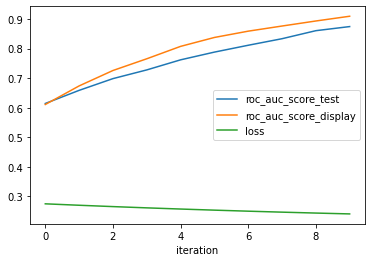

In [15]:
class ClassificationTask(btf.TorchTrainingTask):
    def initialize_task(self, data):
        self.metric_pool = bt.MetricPool().add_sklearn(roc_auc_score)
        self.settings.epoch_count = 10
        self.settings.batch_size = 1000
        self.settings.mini_match_size = None
        self.setup_batcher(data, [get_feature_extractor(), get_binary_label_extractor()])
        self.setup_model(btf.Factories.FullyConnected([10],'features',btf.Conventions.LabelFrame))
        
task = ClassificationTask()
result = task.run(get_binary_classification_bundle())
pd.DataFrame(result['output']['history']).set_index('iteration').plot()

## Multilabel classification

We will also demonstrate how the system works on multilabel classification. Let's create a bundle from the well-known `iris` dataset.

In [16]:
def get_multilabel_classification_bundle():
    ds = datasets.load_iris()
    features = pd.DataFrame(ds['data'], columns=ds['feature_names'])
    df = pd.DataFrame(ds['target_names'][ds['target']], columns = ['label'])
    df['split'] = bt.train_display_test_split(df, 0.2, 0.2, 'label')
    bundle = bt.DataBundle(index=df, features=features)
    return bundle
    
get_multilabel_classification_bundle().index.head()

,label,split
0,setosa,train
1,setosa,train
2,setosa,train
3,setosa,test
4,setosa,display


In [17]:
def get_multilabel_extractor():
    label_extractor = (bt.PlainExtractor
                   .build(btf.Conventions.LabelFrame)
                   .index()
                   .apply(take_columns=['label'], transformer=dft.DataFrameTransformerFactory.default_factory())
                  )
    return label_extractor

db = get_multilabel_classification_bundle()
idb = bt.IndexedDataBundle(db.index, db)
test_extractor( get_multilabel_extractor(), idb).head()

,label_setosa,label_versicolor,label_virginica
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


<AxesSubplot:xlabel='iteration'>

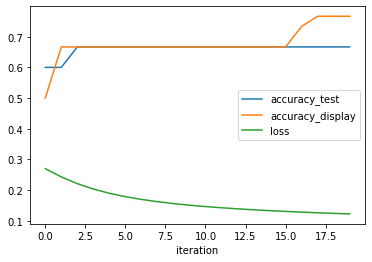

In [18]:
class ClassificationTask(btf.TorchTrainingTask):
    def initialize_task(self, data):
        self.metric_pool = bt.MetricPool().add(bt.MulticlassMetrics())
        self.settings.epoch_count = 20
        self.settings.batch_size = 10000
        self.settings.mini_match_size = None
        
        self.setup_batcher(data, [get_feature_extractor(), get_multilabel_extractor()])
        self.optimizer_ctor.kwargs.lr = 1
        self.setup_model(btf.Factories.FullyConnected([],'features',btf.Conventions.LabelFrame))
        
task = ClassificationTask()
result = task.run(get_multilabel_classification_bundle())
pd.DataFrame(result['output']['history']).set_index('iteration').plot()

## Best practices



### How to get aboard?



### Configuring experiments



Setting the sequence of the experiments is hard. It gets even harder if you don't do it right: in the end, you might end up with lots of jobs at Sagemaker with some metrics, but no one knows what are the parameters of the jobs, or how to use, reuse or reproduce them. To avoid these issues we recommend:

* Configure with parameters, not code. This is not a good practice, when to conduct an experiment, you change something in the code, and then change it back after the experiment. Instead, you put the code, required by the experiment, into the network and isolate it with flags. Ideally, you are able to reproduce any past experiments you had by settings the corresponding parameters.
* If there is a functionality that we may require in other experiments, we isolate it in the separate entities, and the parameters are contained in this entities, _not_ in `TorchTrainingTask` subclass. Examply here is `optimizer_ctor` which contains all the parameters of the optimizer. Don't duplicate settings fields.
* Give meaningful names to the tasks, that represent the important parameters.

To do so, we offer tro-tier initialization. First tier is the Task, such as classification Task. It should be functionable from the start, so use defaults for all the parameters you can:

In [19]:
class ClassificationTask(btf.TorchTrainingTask):
    def __init__(self):
        super(ClassificationTask, self).__init__()
        self.hidden_size = (50,)
    
    def initialize_task(self, data):
        self.metric_pool = bt.MetricPool().add(bt.MulticlassMetrics())
        self.setup_batcher(data, [get_feature_extractor(), get_multilabel_extractor()])
        self.setup_model(btf.Factories.FullyConnected(self.hidden_size,'features',btf.Conventions.LabelFrame))
        

Then, we recommend to create the function that accept all the parameters you want to use, and applies them in the corresponding fields:

In [20]:
def create_task(epoch_count=20, network_size=(50,), learning_rate = 1, algorithm ='Adam'):
    task = ClassificationTask()
    task.settings.epoch_count = epoch_count
    task.hidden_size = network_size
    task.optimizer_ctor.kwargs.lr = learning_rate
    task.optimizer_ctor.type='torch.optim:'+algorithm
    return task
    
create_task()

We can safely do this, because all the initialization happens in `late_initialization`, so, after we actually execute the task. Hence, we can modify the parameters after the object has been created.

To maintain the meaningful names, use this class:

In [21]:
from tg.common.delivery.sagemaker import Autonamer

creator = Autonamer(create_task)
tasks = creator.build_tasks(
    network_size=[ (), (10,), (10,10) ],
    learning_rate = [0.1, 0.3, 1],
    algorithm = ['Adam','SGD']
)
tasks[-1].info['name']

'NS10-10-LR1-ASGD'

`Autonamer` accepts the ranges of each argument of the `create_task`, then runs to all possible combinations, create a task with these parameters and also assigns the name to it, trying to abbreviate the name of the argument and shorten it's value.

In [22]:
results = {}
for task in Query.en(tasks).feed(fluq.with_progress_bar()):
    result = task.run(get_multilabel_classification_bundle())
    results[task.info['name']] = pd.DataFrame(result['output']['history']).set_index('iteration').accuracy_test

  0%|          | 0/18 [00:00<?, ?it/s]

<AxesSubplot:xlabel='iteration'>

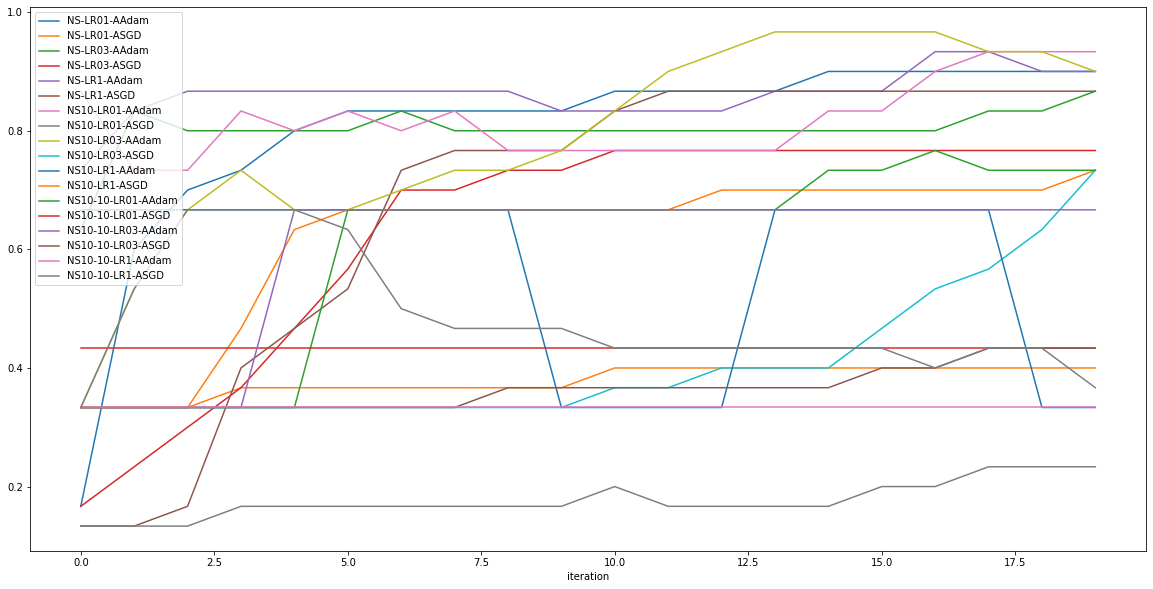

In [23]:
from matplotlib import pyplot as plt
_, ax = plt.subplots(1,1,figsize=(20,10))
rdf = pd.DataFrame(results)
rdf.plot(ax=ax)

<AxesSubplot:>

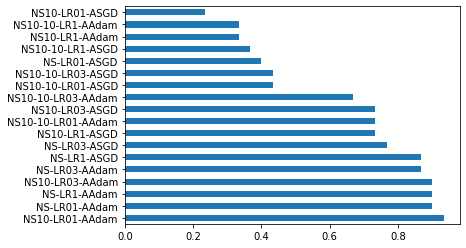

In [24]:
rdf.iloc[-1].sort_values(ascending=False).plot(kind='barh')

Now note, that all the parameters are available as fields somewhere deep in the `task` object. That means that hyperparameter optimization, explained in `tg.common.ml.single_frame` remains available.